In [1]:
import sys
sys.path.append("..")

from src import uilc
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def esc_array(s, W, H, dn =0):
    esc_n = uilc.esc.get_nmax(s, W, H) + dn
    esc_d = uilc.esc.coefficient(s ,esc_n) * H
    return esc_n, uilc.utils.uniformarray(esc_d, esc_n) 
def bc_array(s, W, H, method="esc", uni_n = 2, ep=0.0, dn = 0):
    xe = uilc.disop.find_xe(W, H, s)
    xm = uilc.disop.find_xm(W, H, s, xe)
    if method == "esc":
        esc_n = uilc.disop.get_n_esc_max(s, H, xm, xe) + dn
        esc_d = uilc.esc.coefficient(s, esc_n) * H
        arr = uilc.utils.uniformarray(esc_d, esc_n, 1)
        n = esc_n
    elif method == "uniform":
        d = 2*(xe-ep) / (uni_n-1)
        arr = uilc.utils.uniformarray(d, uni_n, 1)
        n = uni_n 
    
    return n, uilc.disop.get_bc_expansion(arr, s, H, W, xe, xm)

def ds_array(s, W, H, napp=2, k=1.23, init_arr = False):
    sigma = W/(2* napp * k)
    rho, position, F = uilc.disop.solve_system(s, W, H)
    lambd = napp *(rho.size/(W*rho.sum()))
    rho = rho * lambd

    if type(init_arr) == np.ndarray:
        if init_arr.size != napp:
            raise ValueError("array size does not fit with napp. \n napp:{}, shape:{}".format(napp, init_arr.shape))
        arr = init_arr
    else:
        d = W/(napp-1)
        arr = uilc.utils.uniformarray(d, napp)

    return napp, uilc.disop.nomarlization_lq(arr, position, rho, napp, sigma, W)

In [15]:
s = 1.11
alpha =4
H = 0.05
W = alpha * H

# Plot value
xline = np.linspace(-W/2, W/2 , 400)
yline = np.linspace(-W/2, W/2 , 400)
X, Y = np.meshgrid(xline, yline)
n_esc, arr_esc = esc_array(s, W, H, dn=0)
n_bc, arr_bc = bc_array(s, W, H, dn =0)
n_ds, arr_ds = ds_array(s, W, H, napp=n_esc, k=math.sqrt(2)*0.9)

esc_intensity = uilc.utils.lambertian_distribution(xline, np.array([[[0]]]), arr_esc, s, H)
bc_intensity = uilc.utils.lambertian_distribution(xline, np.array([[[0]]]), arr_bc, s, H)
ds_intensity = uilc.utils.lambertian_distribution(xline, np.array([[[0]]]), arr_ds, s, H)

rmse_esc = esc_intensity.std()/esc_intensity.mean()
rmse_bc = bc_intensity.std()/bc_intensity.mean()
rmse_ds = ds_intensity.std()/ds_intensity.mean()

print(rmse_esc*100,"%", n_esc ) 
print(rmse_bc *100,"%", n_bc*2)
print(rmse_ds*100,"%", n_ds)

print("number of LED")

10.11197256178725 % 7
3.7806379372741117 % 6
2.7559262423326345 % 7
number of LED


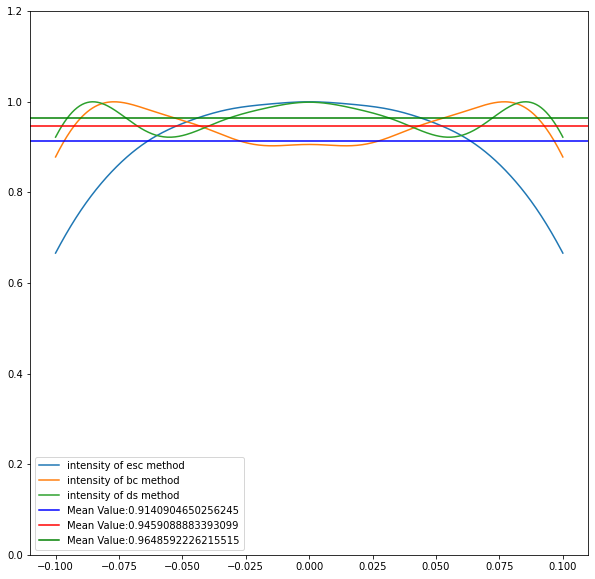

In [16]:
esc_y = esc_intensity[0][0]
esc_y = esc_y/esc_y.max()
bc_y = bc_intensity[0][0]
bc_y = bc_y/bc_y.max()
ds_y = ds_intensity[0][0]
ds_y = ds_y/ds_y.max()

fig= plt.figure(figsize=(10,10))

plt.plot(xline, esc_y, label="intensity of esc method")
plt.plot(xline, bc_y, label="intensity of bc method")
plt.plot(xline, ds_y, label="intensity of ds method")

plt.axhline(y=esc_y.mean(), color='b', label="Mean Value:{}".format(esc_y.mean()))
plt.axhline(y=bc_y.mean(), color='r', label="Mean Value:{}".format(bc_y.mean()))
plt.axhline(y=ds_y.mean(), color='g', label="Mean Value:{}".format(ds_y.mean()))

plt.ylim(0, 1.2)
plt.legend()
plt.show()